In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### Online and Offline Training data

In [2]:
df_on = pd.read_csv('DataSets/ccf_online_stage1_train.csv')
df_off = pd.read_csv('DataSets/ccf_offline_stage1_train.csv')

In [3]:
print("Online Training Data Sample\nShape:"+str(df_on.shape))
df_on.head()

Online Training Data Sample
Shape:(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [4]:
print("Offline Training Data Sample\nShape:"+str(df_off.shape))
df_off.head()

Offline Training Data Sample
Shape:(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


### Test Data (Offline)

In [5]:
df_test = pd.read_csv('DataSets/ccf_offline_stage1_test_revised.csv')
print("Testing Data(Offline) Sample\nShape:"+str(df_test.shape))
df_test.head()

Testing Data(Offline) Sample
Shape:(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


### Converting Coupon to String Type

In [6]:
print('Data type of coupon in different datasets\nOnline: '+str(df_on['Coupon_id'].dtypes)+'\nOffline: '+
      str(df_off['Coupon_id'].dtypes)+'\nTest: '+str(df_test['Coupon_id'].dtypes))
df_off['Coupon_id'] = [int(i) if i==i else i for i in df_off['Coupon_id']]
df_off['Coupon_id'] = df_off['Coupon_id'].apply(lambda x: "{:.0f}".
                                          format(x) if not pd.isnull(x) else x)
df_test['Coupon_id'] = df_test['Coupon_id'].apply(lambda x: "{:.0f}".
                                          format(x) if not pd.isnull(x) else x)
print('After conversion, data type of coupon in different datasets\nOnline: '+str(df_on['Coupon_id'].dtypes)+'\nOffline: '+
      str(df_off['Coupon_id'].dtypes)+'\nTest: '+str(df_test['Coupon_id'].dtypes))

Data type of coupon in different datasets
Online: object
Offline: float64
Test: int64
After conversion, data type of coupon in different datasets
Online: object
Offline: object
Test: object


#### Converting Date to DateTime format

In [7]:
#Online Training Data
df_on['Date'] = pd.to_datetime(df_on["Date"],format='%Y%m%d')
df_on['Date_received'] = pd.to_datetime(df_on["Date_received"],format='%Y%m%d')

#Offline Training Data
df_off['Date'] = pd.to_datetime(df_off["Date"],format='%Y%m%d')
df_off['Date_received'] = pd.to_datetime(df_off["Date_received"],format='%Y%m%d')

### Removing Duplicates from Online and Offline Training Data

In [8]:
#Removing duplicates and giving frequency counts(Count) to each row

#Online
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique["Date_received"]=pd.to_datetime(df_on_unique["Date_received"])
df_on_unique["Date"]=pd.to_datetime(df_on_unique["Date"])

print("Online Training Data Shape:"+str(df_on_unique.shape))

Online Training Data Shape:(5822543, 8)


In [9]:
#Offline
x = 'g8h.|$hTdo+jC9^@'   #garbage value for nan values 
df_off_unique = (df_off.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_off_unique["Date_received"]=pd.to_datetime(df_off_unique["Date_received"])
df_off_unique["Date"]=pd.to_datetime(df_off_unique["Date"])

print("Offline Training Data Shape:"+str(df_off_unique.shape))

Offline Training Data Shape:(1716991, 8)


#### Filling Nan for Distance (OFFLINE)

In [10]:
df_off_unique['Distance'].fillna(df_off_unique['Distance'].mean(), inplace=True)
df_off_unique['Distance'] = df_off_unique.Distance.astype(int)

### Converting Discount Ratio to Rate

In [11]:
#Funtion to convert discount ratio to discount rate
def convert_discount(discount):
    values = []
    for i in discount:
        if ':' in i:
            i = i.split(':')
            rate = round((int(i[0]) - int(i[1]))/int(i[0]),3)
            values.append([int(i[0]),int(i[1]),rate])
        elif '.' in i:
            i = float(i)
            x = 100*i
            values.append([100,int(100-x),i])
            
    discounts = dict(zip(discount,values))      
    return discounts
    

# convert_discount(list(df_of['Discount_rate']))

In [12]:
#ONLINE DATA
df_on_coupon = df_on_unique[(df_on_unique['Coupon_id'].isna()==False) & (df_on_unique['Coupon_id']!='fixed')]
discounts_online = list(df_on_coupon['Discount_rate'].unique())
df_on_coupon.loc[:,('Discount')] = df_on_coupon.loc[:,('Discount_rate')] 
df_on_coupon.loc[:,('Discount_rate')] = df_on_coupon.loc[:,('Discount')].map(convert_discount(discounts_online))
df_on_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_on_coupon.Discount_rate.values.tolist(), index= df_on_coupon.index)
df_on_coupon.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,25104,2,100145044,"[100, 10, 0.9]",2016-03-31,NaT,1,100:10,100,10,0.900
14,209,27710,1,100081876,"[150, 10, 0.933]",2016-05-14,2016-05-14,1,150:10,150,10,0.933
44,236,53305,2,100075632,"[200, 10, 0.95]",2016-02-21,NaT,1,200:10,200,10,0.950
45,236,53305,2,100181719,"[50, 1, 0.98]",2016-02-21,NaT,1,50:1,50,1,0.980
46,236,53305,2,100214552,"[150, 5, 0.967]",2016-02-21,NaT,1,150:5,150,5,0.967


In [13]:
#OFFLINE DATA
df_off_coupon = df_off_unique[(df_off_unique['Coupon_id'].isna()==False)].copy()
discounts_offline = list(df_off_coupon['Discount_rate'].unique())
df_off_coupon.loc[:,('Discount')] = df_off_coupon.loc[:,('Discount_rate')] 
df_off_coupon['Discount_rate'] = df_off_coupon['Discount'].map(convert_discount(discounts_offline))
df_off_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_off_coupon.Discount_rate.values.tolist(), index= df_off_coupon.index)
df_off_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,1433,8735,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833
1,4,1469,2902,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950
2,35,3381,11951,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900
3,35,3381,11951,"[200, 20, 0.9]",0,2016-01-30,NaT,1,200:20,200,20,0.900
4,35,3381,1807,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900


### Training Data (Online + Offline)

In [14]:
df_train = df_on_unique.append(df_off_unique, sort=False)
df_train = df_train.sort_values(by = ['User_id'] )
df_train = df_train.reset_index()
del df_train['index']
print("Training Data(Offline+Online) \nShape:"+str(df_train.shape))
df_train.head()

Training Data(Offline+Online) 
Shape:(7539534, 9)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Distance
0,4,25104,2.0,100145044,100:10,2016-03-31,NaT,1,NaN
1,4,1433,NaN,8735,30:5,2016-02-14,NaT,1,10.0
2,4,1469,NaN,2902,0.95,2016-06-07,NaT,1,10.0
3,4,45612,1.0,NaN,NaN,NaT,2016-03-08,1,NaN
4,35,3381,NaN,11951,200:20,2016-01-30,NaT,1,0.0


### Distributing users into three categores: 
1. users getting coupon
2. users making purchases without coupon
3. users making purchases with coupon

In [15]:
df_off_redeem_coupon = df_off_unique[(df_off_unique['Date'].isna()==False) & (df_off_unique['Coupon_id'].isna()==False)]
df_train_coupon = df_on_coupon.append(df_off_coupon, sort=False)

## Coupon Analysis

## Coupon Distribution for Online, Offline and Test Datasets

In [16]:
coupon_off = set(df_off['Coupon_id'].unique())
coupon_on = set(df_on['Coupon_id'].unique())
coupon_test = set(df_test['Coupon_id'].unique())
len(coupon_off),len(coupon_on),len(coupon_test)

(9739, 27748, 2050)

In [17]:
coupon_on_off = coupon_on.intersection(coupon_off)
coupon_on_test = coupon_on.intersection(coupon_test)
coupon_test_off = coupon_test.intersection(coupon_off)
len(coupon_on_off), len(coupon_on_test), len(coupon_test_off)

(0, 0, 1118)

In [18]:
coupon_only_off = coupon_off - coupon_test
coupon_only_test = coupon_test - coupon_off
len(coupon_only_off),len(coupon_only_test)

(8621, 932)

<img src ="imgs/CouponDistribution.png" width="60%">

### Merchant is constant for a particular Coupon ID

In [19]:
coupon_merchant = pd.DataFrame(df_train_coupon.groupby(['Coupon_id'])['Merchant_id'].nunique())
coupon_merchant.columns = ['NumberOfMerchants']
coupon_merchant['NumberOfMerchants'].nunique()

1

### Discount Rate is constant for a particular Coupon ID

In [20]:
coupon_discount = pd.DataFrame(df_train_coupon.groupby(['Coupon_id'])['Rate'].nunique())
coupon_discount.columns = ['NumberOfDiscounts']
coupon_discount['NumberOfDiscounts'].nunique()

1

### Coupon Redemption Score

In [21]:
#Coupon in offline Dataset
coupon_redemption_offline = pd.DataFrame(df_off_coupon.groupby(['Coupon_id'])['Rate','Date'].count()).reset_index()
coupon_redemption_offline.columns = ['Coupon_id','Coupon_Released', 'Coupon_Redeemed']
coupon_redemption_offline['Coupon_Ratio'] = round(coupon_redemption_offline['Coupon_Redeemed']/coupon_redemption_offline['Coupon_Released'],2)
coupon_redemption_offline.head()

,Coupon_id,Coupon_Released,Coupon_Redeemed,Coupon_Ratio
0,1,5,1,0.20
1,10,32,15,0.47
2,100,7,1,0.14
3,1000,38,4,0.11
4,10000,17,11,0.65


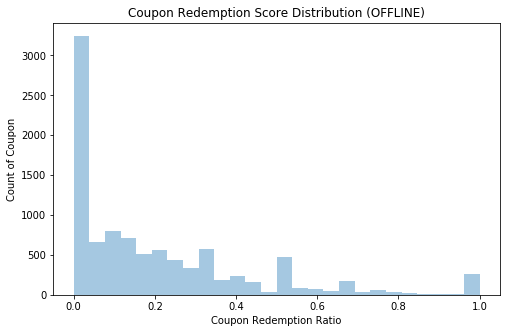

In [22]:
plt.figure(figsize=(8,5))
sns.distplot(coupon_redemption_offline['Coupon_Ratio'],kde=False,bins=26)
plt.xlabel('Coupon Redemption Ratio')
plt.ylabel('Count of Coupon')
plt.title('Coupon Redemption Score Distribution (OFFLINE)')
plt.show()

### Distance Distribution with respect to coupon redemption

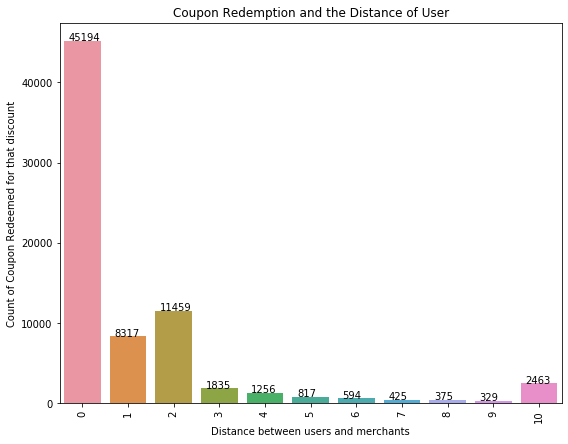

In [23]:
plt.figure(figsize=(9,7))
ax = sns.countplot(df_off_redeem_coupon['Distance'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.xlabel('Distance between users and merchants')
plt.ylabel('Count of Coupon Redeemed for that discount')
plt.title('Coupon Redemption and the Distance of User')
plt.show()

### Duration of coupon

In [24]:
coupon_duration = df_off_coupon.copy()
coupon_duration['DateTrack'] = coupon_duration['Date']
coupon_duration.DateTrack.fillna(coupon_duration.Date_received, inplace=True)
coupon_duration.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate,DateTrack
0,4,1433,8735,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833,2016-02-14
1,4,1469,2902,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950,2016-06-07
2,35,3381,11951,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900,2016-01-29
3,35,3381,11951,"[200, 20, 0.9]",0,2016-01-30,NaT,1,200:20,200,20,0.900,2016-01-30
4,35,3381,1807,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900,2016-01-30


In [25]:
coupon_duration_days =pd.DataFrame(coupon_duration.groupby(['Coupon_id'])['DateTrack'].agg(['min','max'])).reset_index()
coupon_duration_days.columns = ['Coupon_id','StartDate', 'EndDate']
coupon_duration_days['Duration'] = coupon_duration_days['EndDate'] - coupon_duration_days['StartDate']
coupon_duration_days.head()

,Coupon_id,StartDate,EndDate,Duration
0,1,2016-05-13,2016-06-06,24 days
1,10,2016-05-13,2016-05-31,18 days
2,100,2016-05-21,2016-06-12,22 days
3,1000,2016-01-17,2016-02-15,29 days
4,10000,2016-01-02,2016-02-18,47 days


In [26]:
coupon_duration_days['Duration'] = coupon_duration_days['Duration'].dt.days.astype('str')
coupon_duration_days['Duration'] = pd.to_numeric(coupon_duration_days['Duration'],errors="coerce")
coupon_duration_days.head()

,Coupon_id,StartDate,EndDate,Duration
0,1,2016-05-13,2016-06-06,24
1,10,2016-05-13,2016-05-31,18
2,100,2016-05-21,2016-06-12,22
3,1000,2016-01-17,2016-02-15,29
4,10000,2016-01-02,2016-02-18,47


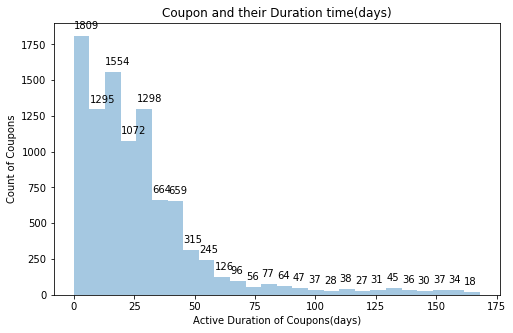

In [27]:
plt.figure(figsize=(8,5))
ax = sns.distplot(coupon_duration_days['Duration'],kde=False,bins=26)
plt.xlabel('Active Duration of Coupons(days)')
plt.ylabel('Count of Coupons')
plt.title('Coupon and their Duration time(days)')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

In [28]:
coupon_duration_days['Duration'].describe()

count    9738.000000
mean       27.109365
std        27.672371
min         0.000000
25%         9.000000
50%        21.000000
75%        35.000000
max       168.000000
Name: Duration, dtype: float64

### First Coupon Release Date

In [42]:
coupon_release_date = pd.DataFrame(df_off_coupon.groupby('Coupon_id')['Date_received']
                                   .min().reset_index(name='ReleaseDate'))
coupon_release_date['First_day'] = pd.to_datetime('20160101',format='%Y%m%d')
coupon_release_date['FirstReleaseDate'] = coupon_release_date['ReleaseDate'] - coupon_release_date['First_day'] 
coupon_release_date['FirstReleaseDate'] = coupon_release_date['FirstReleaseDate'].dt.days.astype('str')
coupon_release_date['FirstReleaseDate'] = pd.to_numeric(coupon_release_date['FirstReleaseDate'],errors="coerce") + 1
coupon_release_date = coupon_release_date[['Coupon_id','FirstReleaseDate']]
coupon_release_date.head()

,Coupon_id,FirstReleaseDate
0,1,134
1,10,134
2,100,135
3,1000,17
4,10000,2


# Time Based Features (Coupon Level)

### Coupon Release List

In [29]:
coupon_release = df_off_coupon.copy()
coupon_release['First_day'] = pd.to_datetime('20160101',format='%Y%m%d')
coupon_release['DayNum'] = coupon_release['Date_received'] - coupon_release['First_day'] 
coupon_release['DayNum'] = coupon_release['DayNum'].dt.days.astype('str')
coupon_release['DayNum'] = pd.to_numeric(coupon_release['DayNum'],errors="coerce") + 1
coupon_release.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate,First_day,DayNum
0,4,1433,8735,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833,2016-01-01,45
1,4,1469,2902,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950,2016-01-01,159
2,35,3381,11951,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900,2016-01-01,29
3,35,3381,11951,"[200, 20, 0.9]",0,2016-01-30,NaT,1,200:20,200,20,0.900,2016-01-01,30
4,35,3381,1807,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900,2016-01-01,30


In [30]:
coupon_release = pd.DataFrame(coupon_release.groupby(['Coupon_id'])['DayNum'].
                              apply(list).reset_index(name='CouponReleaseList'))
coupon_release['CouponReleaseList'] = coupon_release['CouponReleaseList'].apply(lambda x : sorted(set(x)))
coupon_release.head()

,Coupon_id,CouponReleaseList
0,1,"[134, 143, 151, 155, 158]"
1,10,"[134, 135, 136, 137, 138, 139, 140, 141, 142, ..."
2,100,"[135, 142, 143, 147, 148, 150, 164]"
3,1000,"[17, 19, 28, 29, 32, 35, 46]"
4,10000,"[2, 5, 7, 8, 11, 12, 15, 16, 17, 21, 24, 25, 2..."


### Coupon Redeem List

In [31]:
coupon_days = df_off_coupon[df_off_coupon['Date'].isna()==False]
coupon_days['First_day'] = pd.to_datetime('20160101',format='%Y%m%d')
coupon_days['DayNum'] = coupon_days['Date'] - coupon_days['First_day'] 
coupon_days['DayNum'] = coupon_days['DayNum'].dt.days.astype('str')
coupon_days['DayNum'] = pd.to_numeric(coupon_days['DayNum'],errors="coerce") + 1
coupon_days.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate,First_day,DayNum
34,184,3381,9776,"[10, 5, 0.5]",0,2016-01-29,2016-02-28,1,10:5,10,5,0.500,2016-01-01,59
76,417,775,5435,"[30, 5, 0.833]",0,2016-03-29,2016-04-12,1,30:5,30,5,0.833,2016-01-01,103
149,687,6454,14031,"[100, 10, 0.9]",2,2016-01-28,2016-01-30,1,100:10,100,10,0.900,2016-01-01,30
153,687,8594,9353,"[30, 1, 0.967]",2,2016-03-28,2016-04-02,1,30:1,30,1,0.967,2016-01-01,93
159,696,4195,3726,"[100, 10, 0.9]",0,2016-04-11,2016-04-13,1,0.9,100,10,0.900,2016-01-01,104


In [32]:
coupon_days = pd.DataFrame(coupon_days.groupby(['Coupon_id'])['DayNum'].apply(list).reset_index(name='CouponRedeemList'))
coupon_days['CouponRedeemList'] = coupon_days['CouponRedeemList'].apply(lambda x : sorted(set(x)))
coupon_days.head()

,Coupon_id,CouponRedeemList
0,1,[154]
1,10,"[136, 138, 139, 140, 141, 142, 143, 145, 146, ..."
2,100,[142]
3,1000,"[31, 32, 35, 37]"
4,10000,"[8, 12, 15, 16, 17, 25, 26, 27, 28, 31, 49]"


## Coupon Level Features

In [33]:
coupon_redemption_offline

,Coupon_id,Coupon_Released,Coupon_Redeemed,Coupon_Ratio
0,1,5,1,0.20
1,10,32,15,0.47
2,100,7,1,0.14
3,1000,38,4,0.11
4,10000,17,11,0.65
...,...,...,...,...
9733,9993,14,2,0.14
9734,9995,6,0,0.00
9735,9996,59,18,0.31
9736,9997,7,1,0.14


In [43]:
coupon_level_data = coupon_redemption_offline.merge(coupon_duration_days,how='left',on='Coupon_id')
coupon_level_data = coupon_level_data.drop(columns=['StartDate','EndDate'])

#Coupon Redemtion day list
coupon_level_data = pd.merge(coupon_level_data,coupon_days,how='left',on='Coupon_id')
for row in coupon_level_data.loc[coupon_level_data.CouponRedeemList.isnull(), 'CouponRedeemList'].index:
    coupon_level_data.at[row, 'CouponRedeemList'] = []
    
coupon_level_data = pd.merge(coupon_level_data,coupon_release,how='left',on='Coupon_id')
for row in coupon_level_data.loc[coupon_level_data.CouponReleaseList.isnull(), 'CouponReleaseList'].index:
    coupon_level_data.at[row, 'CouponReleaseList'] = []
    
coupon_level_data = pd.merge(coupon_level_data, coupon_release_date,how='left',on='Coupon_id')

coupon_level_data

,Coupon_id,Coupon_Released,Coupon_Redeemed,Coupon_Ratio,Duration,CouponRedeemList,CouponReleaseList,FirstReleaseDate
0,1,5,1,0.20,24,[154],"[134, 143, 151, 155, 158]",134
1,10,32,15,0.47,18,"[136, 138, 139, 140, 141, 142, 143, 145, 146, ...","[134, 135, 136, 137, 138, 139, 140, 141, 142, ...",134
2,100,7,1,0.14,22,[142],"[135, 142, 143, 147, 148, 150, 164]",135
3,1000,38,4,0.11,29,"[31, 32, 35, 37]","[17, 19, 28, 29, 32, 35, 46]",17
4,10000,17,11,0.65,47,"[8, 12, 15, 16, 17, 25, 26, 27, 28, 31, 49]","[2, 5, 7, 8, 11, 12, 15, 16, 17, 21, 24, 25, 2...",2
...,...,...,...,...,...,...,...,...
9733,9993,14,2,0.14,20,"[50, 58]","[38, 39, 40]",38
9734,9995,6,0,0.00,25,[],"[135, 140, 144, 146, 160]",135
9735,9996,59,18,0.31,40,"[144, 147, 149, 151, 153, 155, 159, 160, 161, ...","[141, 142, 143, 144, 146, 147, 148, 149, 150, ...",141
9736,9997,7,1,0.14,27,[141],"[120, 124, 127, 132, 133, 134, 147]",120


In [44]:
coupon_level_data.to_csv('DataSets/DatasetsCreated/coupon_level.csv',index=False)

In [45]:
coupon_level_data.isna().sum()

Coupon_id            0
Coupon_Released      0
Coupon_Redeemed      0
Coupon_Ratio         0
Duration             0
CouponRedeemList     0
CouponReleaseList    0
FirstReleaseDate     0
dtype: int64